## Study of type event recognition for the PETALO experiment using ML

### Imports

In [1]:
import numpy  as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential, load_model
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D,Dropout, Flatten, Dense,BatchNormalization, Activation
from tensorflow.keras.optimizers    import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks     import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics       import TruePositives,Recall

/home/rgadea/anaconda3/envs/tensorflow4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rgadea/anaconda3/envs/ten

In [3]:

# from keras.models import load_model


autoencoderA=load_model('../../../redes_compresoras/20_20/compresorearly_autoencoder_20x20_hiddensize_128_epochs_500_batchsize_200_algoritmo_RMSprop.h5')
autoencoderB=load_model('../../../redes_compresoras/20_20/compresorearly_autoencoder_20x20_hiddensize_256_epochs_500_batchsize_200_algoritmo_RMSprop.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [4]:
phot_list, compt_list = [], []
data_file  = '/home/rgadea/experimentos/datos_julio_2020/full_body_4cmd_images_phot_compt_and_phot_like.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
for im in data['phot_like_images']:
    if len(im)==0:
        continue
    phot_list.append(im.reshape(400))
    
  

### Data Augmentation

In [5]:
compt_images_ori     = np.array(compt_list)
muestras_compt=compt_images_ori.shape[0]
compt_images_ori4=np.zeros([4*muestras_compt,20*20])
for i in range(muestras_compt):
    compt40=compt_images_ori[i].reshape(20,20) 
    compt41=np.flipud(compt40) 
    compt42=np.fliplr(compt40)
    compt43=np.fliplr(compt41)
    compt_images_ori4[i*4]=compt40.reshape(20*20)
    compt_images_ori4[i*4+1]=compt41.reshape(20*20)
    compt_images_ori4[i*4+2]=compt42.reshape(20*20)
    compt_images_ori4[i*4+3]=compt43.reshape(20*20)
    
phot_images_ori       = np.array(phot_list)    
muestras_phot=phot_images_ori.shape[0]
phot_images_ori2=np.zeros([2*muestras_phot,20*20])
for i in range(muestras_phot):
    phot20=phot_images_ori[i].reshape(20,20) 
    phot21=np.flipud(phot20) 
    phot_images_ori2[i*2]=phot20.reshape(20*20)
    phot_images_ori2[i*2+1]=phot21.reshape(20*20)

print(muestras_phot)
print(muestras_compt)

44932
25000


### Join three frames

In [6]:
compt_images_recA     = autoencoderA.predict(compt_images_ori)
compt_images_recA4     = autoencoderA.predict(compt_images_ori4)
phot_images_recA      = autoencoderA.predict(phot_images_ori)
phot_images_recA2      = autoencoderA.predict(phot_images_ori2)
compt_images_recB     = autoencoderB.predict(compt_images_ori)
compt_images_recB4     = autoencoderB.predict(compt_images_ori4)
phot_images_recB      = autoencoderB.predict(phot_images_ori)
phot_images_recB2      = autoencoderB.predict(phot_images_ori2)

compt_images=np.concatenate((compt_images_ori4,compt_images_ori4,compt_images_ori4),axis=1)
phot_images=np.concatenate((phot_images_ori2,phot_images_ori2,phot_images_ori2),axis=1)


In [7]:
phot_images.shape

(89864, 1200)

In [8]:
compt_images.shape

(100000, 1200)

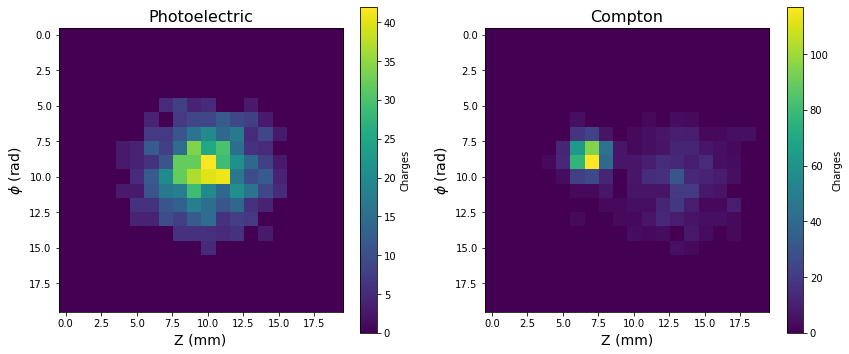

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
fig1 = ax1.imshow( phot_images_ori[4].reshape(20,20))
fig2 = ax2.imshow(compt_images_ori[0].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1

In [10]:
compt_labels = np.zeros(len(compt_images))
phot_labels  = np.ones (len( phot_images))

### Normalization:

In [11]:
# norm_phot_images  = np.array([i/np.max(i) for i in  phot_images])
# norm_compt_images = np.array([i/np.max(i) for i in compt_images])
norm_phot_images  = np.array([i/1.0 for i in  phot_images])
norm_compt_images = np.array([i/1.0 for i in compt_images])

## Inputs for the CNN:

In [12]:
y = np.concatenate((compt_labels,      phot_labels     ))
x = np.concatenate((norm_compt_images, norm_phot_images))

print(y.shape)
print(x.shape)
print(y)

(189864,)
(189864, 1200)
[0. 0. 0. ... 1. 1. 1.]


We want to mix the images so that they are not in order (but labels in the same way too):

In [13]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y= zip(*c)
y = np.array(y)
x = np.array(x).astype('float32') 


Split data in trining, validation and testing:

In [14]:
#######
train_split = 120000
#######
test_split  = 20000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]

In [15]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(20000, 1200) (20000,)
(120000, 1200) (120000,)
(49864, 1200) (49864,)


In [16]:
myset     = set(y_train)
mysettest = set(y_test)
print(myset)
print(mysettest)
print(y)

{0.0, 1.0}
{0.0, 1.0}
[1. 0. 1. ... 0. 0. 1.]


In [17]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(120000, 2)
(49864, 2)
(20000, 2)


120000 train samples
49864 validation samples


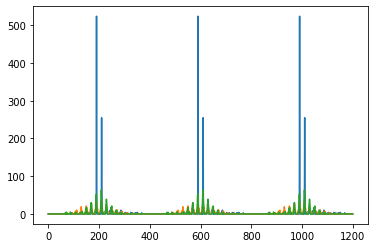

In [18]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test[0])
plt.show()

Reshape data for CNN:

In [19]:
x_train_cnn = x_train.reshape(-1, 3, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 3, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 3, 20, 20, 1)
x_train_cnn.shape

(120000, 3, 20, 20, 1)

In [20]:

# batch_size = 50
nb_classes = 2
# epochs = 30

# input image dimensions
img_rows, img_cols = 20, 20
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (1,2, 2)
# convolution kernel size
kernel_size = (3, 4, 4)

use_regularizer = True
my_regularizer = None
# my_epochs = 50
# hidden_size=320
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(0.00001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'
    
    
import keras.backend as K
# metrics = Metrics()
def sensitivity(y_true, y_pred):
#     y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true[1] * y_pred[1], 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true[1], 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity_compton(y_pred, y_true):
    """Compute the confusion matrix for a set of predictions.

    Parameters
    ----------
    y_pred   : predicted values for a batch if samples (must be binary: 0 or 1)
    y_true   : correct values for the set of samples used (must be binary: 0 or 1)

    Returns
    -------
    out : the specificity
    """
#     check_binary(K.eval(y_true[0]))    # must check that input values are 0 or 
#     check_binary(K.eval(y_pred[0]))    # 
    idea1=K.eval(y_true)
    idea2=K.eval(y_pred)
    TN = np.logical_and(idea1.item(0) == 1, idea2.item(0) == 1)
    FP = np.logical_and(idea1.item(0) == 1, idea2.item(0) == 0)

    # as Keras Tensors
    TN = K.sum(K.variable(TN))
    FP = K.sum(K.variable(FP))

    specificity = TN / (TN + FP + K.epsilon())
    return specifity

Using TensorFlow backend.


In [21]:
layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)
algoritmo='Nadam'
# a fairly small network for speed
cnnmodel = Sequential()
#cnnmodel.add(Conv2D(128, (4, 4), activation='relu', input_shape=(20, 20, 1)))
# cnnmodel.add(Conv2D(64, (2, 2), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(Conv3D(16, kernel_size=kernel_size,
                        padding='same',
                        kernel_regularizer=my_regularizer,
                        data_format='channels_last',
                        input_shape=(3,img_rows,img_cols,1)))
cnnmodel.add(BatchNormalization(momentum=0.6))
cnnmodel.add(Activation('relu'))

cnnmodel.add(MaxPooling3D(pool_size=pool_size))

cnnmodel.add(Conv3D(16, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))
cnnmodel.add(BatchNormalization(momentum=0.6))
cnnmodel.add(Activation('relu'))

cnnmodel.add(MaxPooling3D(pool_size=pool_size))

cnnmodel.add(Conv3D(32, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))
cnnmodel.add(BatchNormalization(momentum=0.6))
cnnmodel.add(Activation('relu'))

cnnmodel.add(MaxPooling3D(pool_size=pool_size))

cnnmodel.add(Conv3D(32, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))

cnnmodel.add(Activation('relu'))
cnnmodel.add(BatchNormalization(momentum=0.6))

cnnmodel.add(Conv3D(64, kernel_size, kernel_regularizer=my_regularizer, padding='same'))

cnnmodel.add(Activation('relu'))
cnnmodel.add(BatchNormalization(momentum=0.6))

cnnmodel.add(Conv3D(64, kernel_size, kernel_regularizer=my_regularizer, padding='same'))

cnnmodel.add(Activation('relu'))
cnnmodel.add(BatchNormalization(momentum=0.6))

cnnmodel.add(Conv3D(128, kernel_size,kernel_regularizer=my_regularizer, padding='same'))

cnnmodel.add(Activation('relu'))
cnnmodel.add(BatchNormalization(momentum=0.6))

cnnmodel.add(Dropout(0.2))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(2, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=algoritmo) #RMSprop())

cnnmodel.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 3, 20, 20, 16)     784       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 3, 20, 20, 16)     64        
_________________________________________________________________
activation (Activation)      (None, 3, 20, 20, 16)     0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 3, 10, 10, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 10, 10, 16)     12304     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 3, 10, 10, 16)     64        
___________________________

In [22]:
batch_size = 1000
epochs     = 200
string_filter='sin_normalizacion+CNNpropia3D'
## To prevent it from memorizing the learning samples when the number of epochs is high

dt = datetime.now().replace(second=0, microsecond=0)
# experimento="CNN_kernel_{}x{}x{}_con_filtro_AE_3_sector_{}x{}x{}_elu".format(kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)
experimento="CNN_clasificacion_phot+phot_like_compton_{}_kernel_{}x{}x{}_input_dimension_{}x{}x{}_elu".format( string_filter,kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)


# optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../../../logs/compton/2020/{}{}{}".format(experimento,algoritmo,dt))
best_model_name='../../../redes_CNN_clasificacion_2_clases/2020/{}_epochs_{}_batchsize_{}_algoritmo_{}_date_{}.h5'.format(experimento,epochs,batch_size,algoritmo,dt)
# dir_path        = '/Users/carmenromoluque/machine-learning-course/'
# best_model_name = dir_path + f'CNN_regression_R_{epochs}_{batch_size}.h5'
model_check     = ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1, save_best_only=True, 
                                  save_weights_only=False, mode='min', period=1)
early_stop      = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, 
                                verbose=1, mode='min', baseline=None)


history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot),
                       callbacks=[tensorboard,model_check, early_stop])

Train on 120000 samples, validate on 49864 samples
Epoch 1/200
119000/120000 [============================>.] - ETA: 0s - loss: 0.8649
Epoch 00001: val_loss improved from inf to 0.72801, saving model to ../../../redes_CNN_clasificacion_2_clases/2020/CNN_clasificacion_phot+phot_like_compton_sin_normalizacion+CNNpropia3D_kernel_3x4x4_input_dimension_20x20x1_elu_epochs_200_batchsize_1000_algoritmo_RMSProp_date_2020-07-29 13:00:00.h5
120000/120000 [==============================] - 15s 124us/sample - loss: 0.8638 - val_loss: 0.7280
Epoch 2/200
119000/120000 [============================>.] - ETA: 0s - loss: 0.7145
Epoch 00002: val_loss did not improve from 0.72801
120000/120000 [==============================] - 9s 76us/sample - loss: 0.7142 - val_loss: 0.7973
Epoch 3/200
119000/120000 [============================>.] - ETA: 0s - loss: 0.7058
Epoch 00003: val_loss improved from 0.72801 to 0.67895, saving model to ../../../redes_CNN_clasificacion_2_clases/2020/CNN_clasificacion_phot+phot_li

In [23]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['loss','val_loss'], ax=ax2)
    max_acc = hist['val_loss'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_loss) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

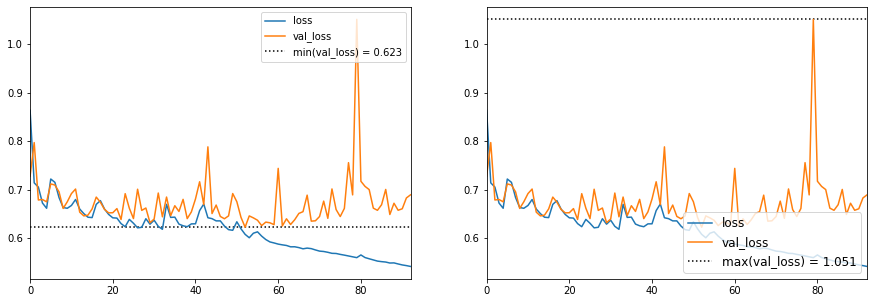

In [24]:
histplot(history)

In [25]:
cnnmodelfin=cnnmodel
# si descomentas la siguiente linea cogera el modelo cuando val_loss fue optimo
cnnmodelbest=load_model(best_model_name)


In [26]:
print(best_model_name)

../../../redes_CNN_clasificacion_2_clases/2020/CNN_clasificacion_phot+phot_like_compton_sin_normalizacion+CNNpropia3D_kernel_3x4x4_input_dimension_20x20x1_elu_epochs_200_batchsize_1000_algoritmo_RMSProp_date_2020-07-29 13:00:00.h5


In [27]:
use_regularizer = True
my_regularizer = None
# my_epochs = 50
# hidden_size=320
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(0.00001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

In [28]:
# prediction = []
# for i in range(len(x_test_cnn)):
#     img = x_test_cnn[i]
#     test_image = image.img_to_array(img)
#     test_image = np.expand_dims(test_image, axis=0)
#     pred = cnnmodel.predict(test_image)
#     prediction.append(pred)
# prediction = np.array(prediction)

In [29]:
prediction=cnnmodelbest.predict(x_test_cnn)
prediction = np.array(prediction)

In [30]:
result2=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result2.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result2.append(1)
    else:
        continue
result2 = np.array(result2)

result2_translate = ['Compt', 'Phot']
result2_names = []
for i in range(len(result2)):
    result2_names.append(result2_translate[result2[i]])
result2_names = np.array(result2_names)

In [31]:
result=result2
result_translate= result2_translate
result_names = result2_names

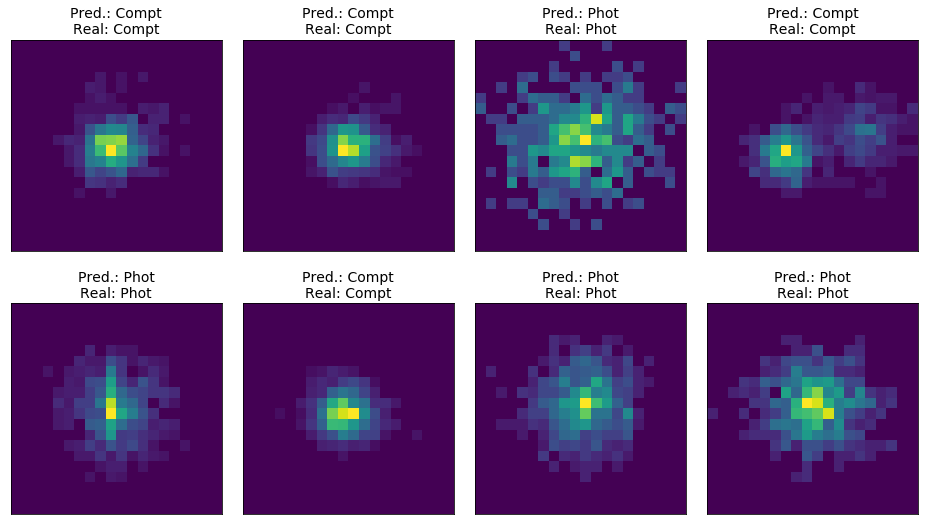

In [32]:
x_test_image = x_test.reshape(len(x_test),3,20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i][0], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [33]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('--------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('--------------------------------')

--------------------------------
# CORRECT PREDICTIONS:
13600 of total 20000 ---> 68.0 %
--------------------------------


In [34]:
tot_true_phot  = np.sum(y_test==1)/100
tot_true_compt = np.sum(y_test==0)/100
print ('True phot+phot_like',tot_true_phot)
print ('True compt',tot_true_compt)
print('True phot  labeled as phot  ---> ', int(np.round(np.sum(result[y_test==1]==1)/tot_true_phot)), '%')
print('True phot  labeled as compt ---> ', int(np.round(np.sum(result[y_test==1]==0)/tot_true_phot)), '%')
print('True compt labeled as compt ---> ', int(np.round(np.sum(result[y_test==0]==0)/tot_true_compt)), '%')
print('True compt labeled as phot  ---> ', int(np.round(np.sum(result[y_test==0]==1)/tot_true_compt)), '%')


True phot+phot_like 95.37
True compt 104.63
True phot  labeled as phot  --->  73 %
True phot  labeled as compt --->  27 %
True compt labeled as compt --->  64 %
True compt labeled as phot  --->  36 %


In [35]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis,: ]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),size= 20,
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[3807 6944]
 [6656 2593]]


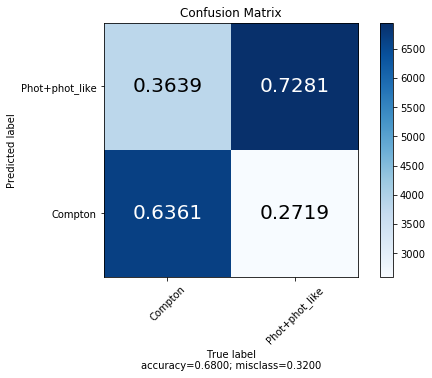

Confusion Matrix normalized
[[0.36385358 0.72811157]
 [0.63614642 0.27188843]]


In [36]:
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
target_names = [ 'Compton','Phot+phot_like']
cm=confusion_matrix( y_test,result, normalize    =None )
cm_transpuesta=np.transpose(cm)
print(np.flip(cm_transpuesta,0))
plot_confusion_matrix(cm           = cm_transpuesta, 
                      normalize    = True,
                      target_names = target_names,
                      title        = "Confusion Matrix")
cm_n=confusion_matrix( y_test,result, normalize    = 'true')
cm_n_transpuesta=np.transpose(cm_n)
print('Confusion Matrix normalized')
print(np.flip(cm_n_transpuesta,0))